### Pseudo-Perplexity (PPL) for CDR3 Sequencing
Use PPL as metric to extract the CDR3 sequence from the RNA sequence. This notebook uses single cell data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/romi/projects/cvc


In [3]:
import os, sys
import pandas as pd
import seaborn as sns
import collections
import ast

from cvc import model_utils
from lab_notebooks.utils import SC_TRANSFORMER, DEVICE, HOME_DIR_GCP
from single_cell_research import cvc_sequencing

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)

MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

In [4]:
import torch
torch.Tensor([1]).cuda()

tensor([1.], device='cuda:0')

#### Prepare Single Cell data
This notebook uses both the fasta file that contains the RNA sequences and the labels (to measure accuracy)

In [4]:
# data below came from https://www.10xgenomics.com/resources/datasets/nsclc-tumor-tcr-enrichment-from-amplified-c-dna-1-standard-2-2-0
fasta_file_path = './single_cell_research/10x_nsclc/vdj_v1_hs_nsclc_t_filtered_contig.fasta'
label_file_path = './single_cell_research/10x_nsclc/vdj_v1_hs_nsclc_t_filtered_contig_annotations.csv'

In [5]:
from Bio import SeqIO
# Create an empty dataframe with columns 'barcode' and 'sequence'
contig_fasta_df = pd.DataFrame(columns=['contig_id', 'sequence'])

# Use SeqIO to parse the FASTA file
for record in SeqIO.parse(fasta_file_path, "fasta"):
    # Add the record's id and sequence to the dataframe
    contig_fasta_df = contig_fasta_df.append({'contig_id': record.id, 'sequence': str(record.seq)}, ignore_index=True)
contig_fasta_df

/tmp/ipykernel_13747/4030663188.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contig_fasta_df = contig_fasta_df.append({'contig_id': record.id, 'sequence': str(record.seq)}, ignore_index=True)
/tmp/ipykernel_13747/4030663188.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contig_fasta_df = contig_fasta_df.append({'contig_id': record.id, 'sequence': str(record.seq)}, ignore_index=True)
/tmp/ipykernel_13747/4030663188.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contig_fasta_df = contig_fasta_df.append({'contig_id': record.id, 'sequence': str(record.seq)}, ignore_index=True)
/tmp/ipykernel_13747/4030663188.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

,contig_id,sequence
0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...
1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...
2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...
3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...
4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...
...,...,...
5095,TGACTAGAGACCCACC-1_contig_1,ATGGGGGAGAGGGGCTGTGCTGAGAGGCGCTGCTGGGCGTCTGGGC...
5096,TGACTAGAGACCCACC-1_contig_3,CTGGGGACACCAGCTCCTCTGGGGTTTGCCACACTCATGATGCACT...
5097,TGGTTAGAGAGGGCTT-1_contig_1,GGGGAGTGGAAACCACAGCCTAGTCCTCTCACCACTGCAGACCAGA...
5098,TGGTTAGAGAGGGCTT-1_contig_2,GGGGAGCTTGGAGAGGGGTGGGTACTGGAGAAGACCAGCCCCTTCG...


In [6]:
# read files
contig_labels = pd.read_csv(label_file_path)
fasta_contig_df_with_labels = contig_fasta_df.merge(contig_labels, on='contig_id')

In [7]:
# read only chains TRA, TRB
fasta_contig_df_with_labels_filtered = fasta_contig_df_with_labels[fasta_contig_df_with_labels['chain'].isin(['TRA', 'TRB'])]
fasta_contig_df_with_labels_filtered = fasta_contig_df_with_labels_filtered[fasta_contig_df_with_labels_filtered['cdr3'] != 'None']
fasta_contig_df_with_labels_filtered

,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,TRBJ1-1,TRBC1,True,True,CASSSQGGTEAFF,TGTGCCAGCAGCTCCCAGGGTGGGACTGAAGCTTTCTTT,7070,5,clonotype194,clonotype194_consensus_2
1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,TRAJ52,TRAC,True,True,CAVAPAGGTSYGKLTF,TGTGCTGTGGCCCCTGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,4152,3,clonotype194,clonotype194_consensus_1
2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,TRBJ2-7,TRBC2,True,True,CASSLYGRSYEQYF,TGTGCCAGCAGTTTATACGGGCGGTCCTACGAGCAGTACTTC,17459,18,clonotype15,clonotype15_consensus_2
3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,TRAJ28,TRAC,True,True,CAENDSGAGSYQLTF,TGTGCAGAGAATGACTCTGGGGCTGGGAGTTACCAACTCACTTTC,5129,4,clonotype15,clonotype15_consensus_1
4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,TRAC,True,False,CGADQGWQQP*ADL,TGTGGAGCAGACCAAGGCTGGCAACAACCGTAAGCTGATTTG,2718,2,clonotype15,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,TRAJ5,TRAC,True,True,CAMRGRDTGRRALTF,TGTGCAATGAGAGGTCGGGACACGGGCAGGAGAGCACTTACTTTT,17250,18,clonotype1130,clonotype1130_consensus_2
5093,TCATTACCACCAGCAC-1_contig_1,TGGGGAGAGCCCAGCACCTCACCCAGAGGACCCCAGTCAGAGGCCC...,TCATTACCACCAGCAC-1,True,True,536,TRB,TRBV4-3,TRBD2,TRBJ2-2,TRBC2,True,True,CASSPTSGFAGELFF,TGCGCCAGCAGTCCCACTAGCGGGTTTGCCGGGGAGCTGTTTTTT,11698,11,clonotype5,clonotype5_consensus_2
5094,TCATTACCACCAGCAC-1_contig_4,ATTGATCCTTTTCTTATATGGGGGTTGAATACACAAGTCAACTTCT...,TCATTACCACCAGCAC-1,True,True,543,TRA,TRAV10,None,TRAJ6,TRAC,True,True,CVVSESGGSYIPTF,TGTGTGGTGAGCGAATCAGGAGGAAGCTACATACCTACATTT,3067,5,clonotype5,clonotype5_consensus_1
5097,TGGTTAGAGAGGGCTT-1_contig_1,GGGGAGTGGAAACCACAGCCTAGTCCTCTCACCACTGCAGACCAGA...,TGGTTAGAGAGGGCTT-1,True,True,710,TRB,TRBV3-1,None,TRBJ2-5,TRBC2,True,True,CASSQERIQETQYF,TGTGCCAGCAGCCAAGAAAGGATTCAGGAGACCCAGTACTTC,8758,10,clonotype1424,clonotype1424_consensus_1


In [10]:
collections.Counter(fasta_contig_df_with_labels_filtered['chain'])

Counter({'TRB': 1838, 'TRA': 1805})

In [11]:
fasta_contig_df_with_labels_filtered_sub = fasta_contig_df_with_labels_filtered.groupby('chain').apply(lambda x: x.sample(250)).reset_index(drop=True)

In [12]:
df_to_use = fasta_contig_df_with_labels_filtered

#### Add Kmers

In [13]:
# create kmers
contig_df_with_kmers = cvc_sequencing.add_kmers(df_to_use)
contig_df_with_kmers

,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,...,kmer_11_offset_2,kmer_12_offset_2,kmer_13_offset_2,kmer_14_offset_2,kmer_15_offset_2,kmer_16_offset_2,kmer_17_offset_2,kmer_18_offset_2,kmer_19_offset_2,kmer_list_offset_2
0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,TRBJ1-1,...,"[GAVAHSDPDWA, AVAHSDPDWAK, VAHSDPDWAKL, AHSDPD...","[GAVAHSDPDWAK, AVAHSDPDWAKL, VAHSDPDWAKLP, AHS...","[GAVAHSDPDWAKL, AVAHSDPDWAKLP, VAHSDPDWAKLPS, ...","[GAVAHSDPDWAKLP, AVAHSDPDWAKLPS, VAHSDPDWAKLPS...","[GAVAHSDPDWAKLPS, AVAHSDPDWAKLPSF, VAHSDPDWAKL...","[GAVAHSDPDWAKLPSF, AVAHSDPDWAKLPSFP, VAHSDPDWA...","[GAVAHSDPDWAKLPSFP, AVAHSDPDWAKLPSFPD, VAHSDPD...","[GAVAHSDPDWAKLPSFPD, AVAHSDPDWAKLPSFPDP, VAHSD...","[GAVAHSDPDWAKLPSFPDP, AVAHSDPDWAKLPSFPDPA, VAH...","[[GAVAHSDPDWA, AVAHSDPDWAK, VAHSDPDWAKL, AHSDP..."
1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,TRAJ52,...,"[GRVFIL.AILH, RVFIL.AILHI, VFIL.AILHIS, FIL.AI...","[GRVFIL.AILHI, RVFIL.AILHIS, VFIL.AILHISD, FIL...","[GRVFIL.AILHIS, RVFIL.AILHISD, VFIL.AILHISDI, ...","[GRVFIL.AILHISD, RVFIL.AILHISDI, VFIL.AILHISDI...","[GRVFIL.AILHISDI, RVFIL.AILHISDIR, VFIL.AILHIS...","[GRVFIL.AILHISDIR, RVFIL.AILHISDIRF, VFIL.AILH...","[GRVFIL.AILHISDIRF, RVFIL.AILHISDIRFQ, VFIL.AI...","[GRVFIL.AILHISDIRFQ, RVFIL.AILHISDIRFQF, VFIL....","[GRVFIL.AILHISDIRFQF, RVFIL.AILHISDIRFQFS, VFI...","[[GRVFIL.AILH, RVFIL.AILHI, VFIL.AILHIS, FIL.A..."
2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,TRBJ2-7,...,"[VSEAQIAEEVE, SEAQIAEEVET, EAQIAEEVETL, AQIAEE...","[VSEAQIAEEVET, SEAQIAEEVETL, EAQIAEEVETLQ, AQI...","[VSEAQIAEEVETL, SEAQIAEEVETLQ, EAQIAEEVETLQK, ...","[VSEAQIAEEVETLQ, SEAQIAEEVETLQK, EAQIAEEVETLQK...","[VSEAQIAEEVETLQK, SEAQIAEEVETLQKP, EAQIAEEVETL...","[VSEAQIAEEVETLQKP, SEAQIAEEVETLQKPP, EAQIAEEVE...","[VSEAQIAEEVETLQKPP, SEAQIAEEVETLQKPPG, EAQIAEE...","[VSEAQIAEEVETLQKPPG, SEAQIAEEVETLQKPPGA, EAQIA...","[VSEAQIAEEVETLQKPPGA, SEAQIAEEVETLQKPPGAP, EAQ...","[[VSEAQIAEEVE, SEAQIAEEVET, EAQIAEEVETL, AQIAE..."
3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,TRAJ28,...,"[GETTMIVRGKK, ETTMIVRGKKG, TTMIVRGKKGI, TMIVRG...","[GETTMIVRGKKG, ETTMIVRGKKGI, TTMIVRGKKGIP, TMI...","[GETTMIVRGKKGI, ETTMIVRGKKGIP, TTMIVRGKKGIPD, ...","[GETTMIVRGKKGIP, ETTMIVRGKKGIPD, TTMIVRGKKGIPD...","[GETTMIVRGKKGIPD, ETTMIVRGKKGIPDD, TTMIVRGKKGI...","[GETTMIVRGKKGIPDD, ETTMIVRGKKGIPDDG, TTMIVRGKK...","[GETTMIVRGKKGIPDDG, ETTMIVRGKKGIPDDGS, TTMIVRG...","[GETTMIVRGKKGIPDDGS, ETTMIVRGKKGIPDDGSS, TTMIV...","[GETTMIVRGKKGIPDDGSS, ETTMIVRGKKGIPDDGSSS, TTM...","[[GETTMIVRGKK, ETTMIVRGKKG, TTMIVRGKKGI, TMIVR..."
4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,...,"[GTVFSK.LRDG, TVFSK.LRDGD, VFSK.LRDGDC, FSK.LR...","[GTVFSK.LRDGD, TVFSK.LRDGDC, VFSK.LRDGDCS, FSK...","[GTVFSK.LRDGDC, TVFSK.LRDGDCS, VFSK.LRDGDCSA, ...","[GTVFSK.LRDGDCS, TVFSK.LRDGDCSA, VFSK.LRDGDCSA...","[GTVFSK.LRDGDCSA, TVFSK.LRDGDCSAS, VFSK.LRDGDC...","[GTVFSK.LRDGDCSAS, TVFSK.LRDGDCSAST, VFSK.LRDG...","[GTVFSK.LRDGDCSAST, TVFSK.LRDGDCSASTP, VFSK.LR...","[GTVFSK.LRDGDCSASTP, TVFSK.LRDGDCSASTPR, VFSK....","[GTVFSK.LRDGDCSASTPR, TVFSK.LRDGDCSASTPRD, VFS...","[[GTVFSK.LRDG, TVFSK.LRDGD, VFSK.LRDGDC, FSK.L..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,TRAJ5,...,"[EPVHREV.GDT, PVHREV.GDTH, VHREV.GDTH., HREV.G...","[EPVHREV.GDTH, PVHREV.GDTH., VHREV.GDTH.F, HRE...","[EPVHREV.GDTH., PVHREV.GDTH.F, VHREV.GDTH.FA, ...","[EPVHREV.GDTH.F, PVHREV.GDTH.FA, VHREV.G

#### Calculate PPL

In [15]:
# get model and tokenizer
my_model, my_tok = model_utils.get_model_tokenizer(model_dir=SC_TRANSFORMER , method="mean", device=DEVICE, max_len=120)

In [16]:
# first flatten the list of lists kmer_list_offset_0, kmer_list_offset_1, kmer_list_offset_2
def join_kmer_lists(df_kmers):
    df_kmers['kmer_list_flat'] = df_kmers['kmer_list_offset_0'] + df_kmers['kmer_list_offset_1'] + df_kmers['kmer_list_offset_2']
    df_kmers['kmer_list_flat'] = df_kmers['kmer_list_flat'].apply(lambda x: [item for sublist in x for item in sublist])

    def flatten_list(l):
        return [item for sublist in l for item in sublist]

    # add offset number row
    df_kmers['kmer_offsets'] = df_kmers.apply(
        lambda x: [0]*len(flatten_list(x['kmer_list_offset_0']))
                  + [1]*len(flatten_list(x['kmer_list_offset_1']))
                  + [2]*len(flatten_list(x['kmer_list_offset_2'])),
        axis=1)
    return df_kmers

In [17]:
contig_df_with_kmers = join_kmer_lists(contig_df_with_kmers)
contig_df_with_kmers

,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,...,kmer_13_offset_2,kmer_14_offset_2,kmer_15_offset_2,kmer_16_offset_2,kmer_17_offset_2,kmer_18_offset_2,kmer_19_offset_2,kmer_list_offset_2,kmer_list_flat,kmer_offsets
0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,TRBJ1-1,...,"[GAVAHSDPDWAKL, AVAHSDPDWAKLP, VAHSDPDWAKLPS, ...","[GAVAHSDPDWAKLP, AVAHSDPDWAKLPS, VAHSDPDWAKLPS...","[GAVAHSDPDWAKLPS, AVAHSDPDWAKLPSF, VAHSDPDWAKL...","[GAVAHSDPDWAKLPSF, AVAHSDPDWAKLPSFP, VAHSDPDWA...","[GAVAHSDPDWAKLPSFP, AVAHSDPDWAKLPSFPD, VAHSDPD...","[GAVAHSDPDWAKLPSFPD, AVAHSDPDWAKLPSFPDP, VAHSD...","[GAVAHSDPDWAKLPSFPDP, AVAHSDPDWAKLPSFPDPA, VAH...","[[GAVAHSDPDWA, AVAHSDPDWAK, VAHSDPDWAKL, AHSDP...","[WGLLLTVTLIG, GLLLTVTLIGQ, LLLTVTLIGQS, LLTVTL...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,TRAJ52,...,"[GRVFIL.AILHIS, RVFIL.AILHISD, VFIL.AILHISDI, ...","[GRVFIL.AILHISD, RVFIL.AILHISDI, VFIL.AILHISDI...","[GRVFIL.AILHISDI, RVFIL.AILHISDIR, VFIL.AILHIS...","[GRVFIL.AILHISDIR, RVFIL.AILHISDIRF, VFIL.AILH...","[GRVFIL.AILHISDIRF, RVFIL.AILHISDIRFQ, VFIL.AI...","[GRVFIL.AILHISDIRFQ, RVFIL.AILHISDIRFQF, VFIL....","[GRVFIL.AILHISDIRFQF, RVFIL.AILHISDIRFQFS, VFI...","[[GRVFIL.AILH, RVFIL.AILHI, VFIL.AILHIS, FIL.A...","[WGECLSCEPFS, GECLSCEPFSI, ECLSCEPFSIF, CLSCEP...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,TRBJ2-7,...,"[VSEAQIAEEVETL, SEAQIAEEVETLQ, EAQIAEEVETLQK, ...","[VSEAQIAEEVETLQ, SEAQIAEEVETLQK, EAQIAEEVETLQK...","[VSEAQIAEEVETLQK, SEAQIAEEVETLQKP, EAQIAEEVETL...","[VSEAQIAEEVETLQKP, SEAQIAEEVETLQKPP, EAQIAEEVE...","[VSEAQIAEEVETLQKPP, SEAQIAEEVETLQKPPG, EAQIAEE...","[VSEAQIAEEVETLQKPPG, SEAQIAEEVETLQKPPGA, EAQIA...","[VSEAQIAEEVETLQKPPGA, SEAQIAEEVETLQKPPGAP, EAQ...","[[VSEAQIAEEVE, SEAQIAEEVET, EAQIAEEVETL, AQIAE...","[GFLRPK.LKRW, FLRPK.LKRWR, LRPK.LKRWRR, RPK.LK...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,TRAJ28,...,"[GETTMIVRGKKGI, ETTMIVRGKKGIP, TTMIVRGKKGIPD, ...","[GETTMIVRGKKGIP, ETTMIVRGKKGIPD, TTMIVRGKKGIPD...","[GETTMIVRGKKGIPD, ETTMIVRGKKGIPDD, TTMIVRGKKGI...","[GETTMIVRGKKGIPDD, ETTMIVRGKKGIPDDG, TTMIVRGKK...","[GETTMIVRGKKGIPDDG, ETTMIVRGKKGIPDDGS, TTMIVRG...","[GETTMIVRGKKGIPDDGS, ETTMIVRGKKGIPDDGSS, TTMIV...","[GETTMIVRGKKGIPDDGSS, ETTMIVRGKKGIPDDGSSS, TTM...","[[GETTMIVRGKK, ETTMIVRGKKG, TTMIVRGKKGI, TMIVR...","[GEKPL.LLEER, EKPL.LLEERK, KPL.LLEERKE, PL.LLE...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,...,"[GTVFSK.LRDGDC, TVFSK.LRDGDCS, VFSK.LRDGDCSA, ...","[GTVFSK.LRDGDCS, TVFSK.LRDGDCSA, VFSK.LRDGDCSA...","[GTVFSK.LRDGDCSA, TVFSK.LRDGDCSAS, VFSK.LRDGDC...","[GTVFSK.LRDGDCSAS, TVFSK.LRDGDCSAST, VFSK.LRDG...","[GTVFSK.LRDGDCSAST, TVFSK.LRDGDCSASTP, VFSK.LR...","[GTVFSK.LRDGDCSASTP, TVFSK.LRDGDCSASTPR, VFSK....","[GTVFSK.LRDGDCSASTPR, TVFSK.LRDGDCSASTPRD, VFS...","[[GTVFSK.LRDG, TVFSK.LRDGD, VFSK.LRDGDC, FSK.L...","[WELCFLNS.GM, ELCFLNS.GME, LCFLNS.GMET, CFLNS....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,TRAJ5,...,"[EPVHREV.GDTH., PVHREV.GDTH.F, VHREV.GDTH.FA, ...","[EPVHREV.GDTH.F, PVHREV.GDTH.FA, VHREV.GDTH.FA...","[EPVHREV.GDTH.FA, PVHREV.GDTH.FAI, VHREV.GDTH....","[EPVHREV.GDTH.FAI, PVHREV.GDTH.FAIP, VHREV.GDT

In [18]:
df_kmers = contig_df_with_kmers

In [ ]:
# calc pseudo perplexity for each kmer
from tqdm.auto import tqdm
tqdm.pandas()
df_kmers['pseudo_perplexity'] = df_kmers['kmer_list_flat'].progress_apply(
    lambda kmer_list: [cvc_sequencing.calc_pseudo_perplexity(my_model, my_tok, kmer, DEVICE) for kmer in kmer_list],
)

# now get the min pseudo perplexity for each sequence
df_kmers['min_pseudo_perplexity'] = df_kmers['pseudo_perplexity'].apply(lambda x: min(x))

# now get the sequence with the min pseudo perplexity
df_kmers['min_pseudo_perplexity_seq'] = df_kmers.apply(
    lambda row: row['kmer_list_flat'][
        row['pseudo_perplexity'].index(row['min_pseudo_perplexity'])
    ], axis=1)

# now get the offset of the sequence with the min pseudo perplexity
df_kmers['min_pseudo_perplexity_offset'] = df_kmers.apply(
    lambda row: row['kmer_offsets'][
        row['pseudo_perplexity'].index(row['min_pseudo_perplexity'])
    ], axis=1)

  0%|          | 0/3643 [00:00<?, ?it/s]

In [ ]:
df_kmers

In [ ]:
# output to csv
df_kmers.to_csv("./single_cell_research/10x_nsclc/df_kmers11-19_10x_scData_all.csv")

In [17]:
# load from csv
df_kmers_csv = pd.read_csv("./single_cell_research/10x_nsclc/df_kmers11-19_10x_scData_all.csv", engine="pyarrow")
df_kmers=df_kmers_csv
df_kmers['pseudo_perplexity'] = df_kmers['pseudo_perplexity'].apply(lambda x: ast.literal_eval(x))
df_kmers['kmer_list_flat'] = df_kmers['kmer_list_flat'].apply(lambda x: ast.literal_eval(x))

#### Evaluate Results

##### Exact match distribution

In [18]:
# add column that is 1 if min pseudo perplexity is equal to cdr3 column
df_kmers['min_pseudo_perplexity_is_cdr3'] = df_kmers.apply(
    lambda row: 1 if row['min_pseudo_perplexity_seq'] == row['cdr3'] else 0, axis=1)

In [19]:
df_kmers

,,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,...,kmer_18_offset_2,kmer_19_offset_2,kmer_list_offset_2,kmer_list_flat,kmer_offsets,pseudo_perplexity,min_pseudo_perplexity,min_pseudo_perplexity_seq,min_pseudo_perplexity_offset,min_pseudo_perplexity_is_cdr3
0,0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,...,"['GAVAHSDPDWAKLPSFPD', 'AVAHSDPDWAKLPSFPDP', '...","['GAVAHSDPDWAKLPSFPDP', 'AVAHSDPDWAKLPSFPDPA',...","[['GAVAHSDPDWA', 'AVAHSDPDWAK', 'VAHSDPDWAKL',...","[WGLLLTVTLIG, GLLLTVTLIGQ, LLLTVTLIGQS, LLTVTL...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[106.14214324951172, 37.75660705566406, 31.564...",1.743439,CASSSQGGTEAFF,2,1
1,1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,...,"['GRVFIL.AILHISDIRFQ', 'RVFIL.AILHISDIRFQF', '...","['GRVFIL.AILHISDIRFQF', 'RVFIL.AILHISDIRFQFS',...","[['GRVFIL.AILH', 'RVFIL.AILHI', 'VFIL.AILHIS',...","[WGECLSCEPFS, GECLSCEPFSI, ECLSCEPFSIF, CLSCEP...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[160.05166625976562, 63.66621398925781, 83.640...",1.660303,CAVAPAGGTSYGKLTF,0,1
2,2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,...,"['VSEAQIAEEVETLQKPPG', 'SEAQIAEEVETLQKPPGA', '...","['VSEAQIAEEVETLQKPPGA', 'SEAQIAEEVETLQKPPGAP',...","[['VSEAQIAEEVE', 'SEAQIAEEVET', 'EAQIAEEVETL',...","[GFLRPK.LKRW, FLRPK.LKRWR, LRPK.LKRWRR, RPK.LK...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[151.86192321777344, 422.26971435546875, 262.5...",1.910294,CTSVPAVYTGGPTSSTSGR,0,0
3,3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,...,"['GETTMIVRGKKGIPDDGS', 'ETTMIVRGKKGIPDDGSS', '...","['GETTMIVRGKKGIPDDGSS', 'ETTMIVRGKKGIPDDGSSS',...","[['GETTMIVRGKK', 'ETTMIVRGKKG', 'TTMIVRGKKGI',...","[GEKPL.LLEER, EKPL.LLEERK, KPL.LLEERKE, PL.LLE...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[329.4343566894531, 268.15167236328125, 378.93...",1.089288,CKLQLLNLETQLSTFVQR,0,0
4,4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,...,"['GTVFSK.LRDGDCSASTP', 'TVFSK.LRDGDCSASTPR', '...","['GTVFSK.LRDGDCSASTPR', 'TVFSK.LRDGDCSASTPRD',...","[['GTVFSK.LRDG', 'TVFSK.LRDGD', 'VFSK.LRDGDC',...","[WELCFLNS.GM, ELCFLNS.GME, LCFLNS.GMET, CFLNS....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[750.2579956054688, 550.3450927734375, 814.998...",1.570277,CISQPPSPAMQASTSVEQ,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,...,"['EPVHREV.GDTH.FAIPG', 'PVHREV.GDTH.FAIPGN', '...","['EPVHREV.GDTH.FAIPGN', 'PVHREV.GDTH.FAIPGNL',...","[['EPVHREV.GDT', 'PVHREV.GDTH', 'VHREV.GDTH.',...","[GSQYIEKCEVT, SQYIEKCEVTH, QYIEKCEVTHT, YIEKCE...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[104.66476440429688, 105.37687683105469, 234.0...",1.506867,CAMRGRDTGRRALTF,1,1
3639,5093,TCATTACCACCAGCAC-1_contig_1,TGGGGAGAGCCCAGCACCTCACCCAGAGGACCCCAGTCAGAGGCCC...,TCATTACCACCAGCAC-1,True,True,536,TRB,TRBV4-3,TRBD2,...,"['GRAQHLTQRTPVRGPISD', 'RAQHLTQRTPVRGPISDP', '...","['GRAQHLTQRTPVRGPISDP', 'RAQHLTQRTPVRGPISDPR',...","[['GRAQHLTQRTP', 'RAQHLTQRTPV', 'AQHLTQRTPVR',...","[WGEPSTSPRGP, GEPSTSPRGPQ, EPSTSPRGPQS, PSTSPR...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[62.8488883972168, 109.8691177368164, 82.02334...",1.065644,CASSPTSGFAGELFF,1,1
3640,5094,TCATTACCACCAGCAC-1_contig_4,ATTGATCCTTTTCTTATATGGGGGTTGAATACACAAGTCAACTTCT...,TCATTACCACCAGCAC-1,True,True,543,TRA,TRAV10,None,...,"['.SFSYMGVEYTSQLLGAD', 'SFSYMGVEYTSQLLGADL', '...","['.SFSYMGVEYTSQLLGADL', 'SFSYMGVEYTSQLLGADLC',...","[['.SFSYMGVE

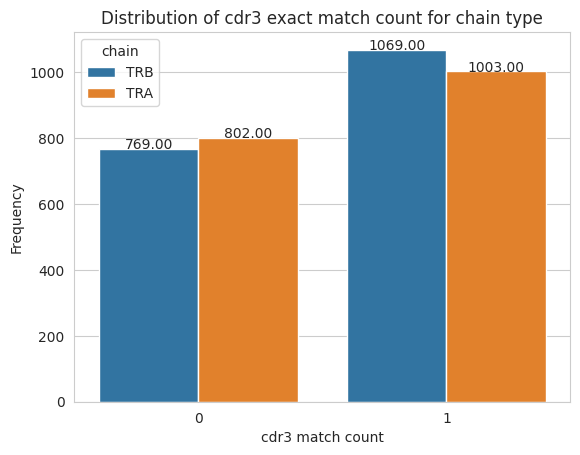

In [28]:
import matplotlib.pyplot as plt
# plot the distribution of cdr3 match count for chain type
sns.countplot(x='min_pseudo_perplexity_is_cdr3', hue='chain', data=df_kmers)
plt.title("Distribution of cdr3 exact match count for chain type")
# set x axis label
plt.xlabel("cdr3 match count")
# set y axis label
plt.ylabel("Frequency")
# add labels on top of bars
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2.,
                   p.get_height(), '{:1.2f}'.format(p.get_height()),
                   ha="center")
# export plot in svg format high quality
plt.savefig("./single_cell_research/figures/10x_scData_all_cdr3_match_count.svg", format="svg", dpi=1200)
plt.show()

##### Top X sequences for chain type distribution

In [21]:
import ast
# add top 5 sequences with the lowest pseudo perplexity
X=10
df_kmers_topX = df_kmers.copy()

df_kmers_topX['pseudo_perplexity_top'+str(X)] = df_kmers_topX['pseudo_perplexity'].apply(lambda x: sorted(x)[:X])
df_kmers_topX['pseudo_perplexity_top'+str(X)+'_seq'] = df_kmers_topX.apply(
    lambda row: [row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][0])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][1])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][2])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][3])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][4])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][5])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][6])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][7])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][8])
                 ], row['kmer_list_flat'][
                     row['pseudo_perplexity'].index(row['pseudo_perplexity_top'+str(X)][9])
                 ]], axis=1)

In [22]:
df_kmers_topX

,,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,...,kmer_list_offset_2,kmer_list_flat,kmer_offsets,pseudo_perplexity,min_pseudo_perplexity,min_pseudo_perplexity_seq,min_pseudo_perplexity_offset,min_pseudo_perplexity_is_cdr3,pseudo_perplexity_top10,pseudo_perplexity_top10_seq
0,0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,...,"[['GAVAHSDPDWA', 'AVAHSDPDWAK', 'VAHSDPDWAKL',...","[WGLLLTVTLIG, GLLLTVTLIGQ, LLLTVTLIGQS, LLTVTL...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[106.14214324951172, 37.75660705566406, 31.564...",1.743439,CASSSQGGTEAFF,2,1,"[1.7434391975402832, 2.8285765647888184, 2.983...","[CASSSQGGTEAFF, CREAQRSRLHSQDPACK, CISVPAAPRVG..."
1,1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,...,"[['GRVFIL.AILH', 'RVFIL.AILHI', 'VFIL.AILHIS',...","[WGECLSCEPFS, GECLSCEPFSI, ECLSCEPFSIF, CLSCEP...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[160.05166625976562, 63.66621398925781, 83.640...",1.660303,CAVAPAGGTSYGKLTF,0,1,"[1.6603034734725952, 3.597917318344116, 3.8513...","[CAVAPAGGTSYGKLTF, CAVAPAGGTSYGKL, CAVAPAGGTSY..."
2,2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,...,"[['VSEAQIAEEVE', 'SEAQIAEEVET', 'EAQIAEEVETL',...","[GFLRPK.LKRW, FLRPK.LKRWR, LRPK.LKRWRR, RPK.LK...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[151.86192321777344, 422.26971435546875, 262.5...",1.910294,CTSVPAVYTGGPTSSTSGR,0,0,"[1.9102938175201416, 2.363219738006592, 3.3031...","[CTSVPAVYTGGPTSSTSGR, CASSLYGRSYEQYF, CTSVPAVY..."
3,3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,...,"[['GETTMIVRGKK', 'ETTMIVRGKKG', 'TTMIVRGKKGI',...","[GEKPL.LLEER, EKPL.LLEERK, KPL.LLEERKE, PL.LLE...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[329.4343566894531, 268.15167236328125, 378.93...",1.089288,CKLQLLNLETQLSTFVQR,0,0,"[1.0892882347106934, 1.6689947843551636, 1.690...","[CKLQLLNLETQLSTFVQR, CKLQLLNLETQLSTF, CKLQLLNL..."
4,4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,...,"[['GTVFSK.LRDG', 'TVFSK.LRDGD', 'VFSK.LRDGDC',...","[WELCFLNS.GM, ELCFLNS.GME, LCFLNS.GMET, CFLNS....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[750.2579956054688, 550.3450927734375, 814.998...",1.570277,CISQPPSPAMQASTSVEQ,1,0,"[1.5702770948410034, 2.56619930267334, 3.08404...","[CISQPPSPAMQASTSVEQ, CISQPPSPAMQASTSVEQT, CRHL..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,...,"[['EPVHREV.GDT', 'PVHREV.GDTH', 'VHREV.GDTH.',...","[GSQYIEKCEVT, SQYIEKCEVTH, QYIEKCEVTHT, YIEKCE...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[104.66476440429688, 105.37687683105469, 234.0...",1.506867,CAMRGRDTGRRALTF,1,1,"[1.5068665742874146, 4.448286533355713, 4.8284...","[CAMRGRDTGRRALTF, CAMRGRDTGRRAL, CAMRGRDTGRRAL..."
3639,5093,TCATTACCACCAGCAC-1_contig_1,TGGGGAGAGCCCAGCACCTCACCCAGAGGACCCCAGTCAGAGGCCC...,TCATTACCACCAGCAC-1,True,True,536,TRB,TRBV4-3,TRBD2,...,"[['GRAQHLTQRTP', 'RAQHLTQRTPV', 'AQHLTQRTPVR',...","[WGEPSTSPRGP, GEPSTSPRGPQ, EPSTSPRGPQS, PSTSPR...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[62.8488883972168, 109.8691177368164, 82.02334...",1.065644,CASSPTSGFAGELFF,1,1,"[1.065644383430481, 3.2747838497161865, 3.5993...","[CASSPTSGFAGELFF, CISAPAVPLAG, CISAPAVPLAGLPGS..."
3640,5094,TCATTACCACCAGCAC-1_contig_4,ATTGATCCTTTTCTTATATGGGGGTTGAATACACAAGTCAACTTCT...,TCATTACCACCAGCAC-1,True,True,543,TRA,TRAV10,None,...,"[['.SFSYMGVEYT', 'SFSYMGVEYTS', 'FSYMGVEYTSQ',...","[IDPFLIWGLNT, DPFLIWGLNTQ, PFLIWGLNTQV, FLIWGL

In [23]:
# compare the top X sequences with the cdr3 sequence
df_kmers_topX['cdr3_match_topX'] = df_kmers_topX.apply(
    lambda row: [row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][0],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][1],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][2],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][3],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][4],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][5],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][6],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][7],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][8],
                 row['cdr3'] == row['pseudo_perplexity_top'+str(X)+'_seq'][9]] ,axis=1)
# get the number of matches
df_kmers_topX['cdr3_match_topX_count'] = df_kmers_topX['cdr3_match_topX'].apply(lambda x: sum(x))

In [24]:
topX_min=df_kmers_topX[(df_kmers_topX['cdr3_match_topX_count'] > 0) & (df_kmers_topX['cdr3'] == df_kmers_topX['min_pseudo_perplexity_seq'])]
topX_min

,,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,...,kmer_offsets,pseudo_perplexity,min_pseudo_perplexity,min_pseudo_perplexity_seq,min_pseudo_perplexity_offset,min_pseudo_perplexity_is_cdr3,pseudo_perplexity_top10,pseudo_perplexity_top10_seq,cdr3_match_topX,cdr3_match_topX_count
0,0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[106.14214324951172, 37.75660705566406, 31.564...",1.743439,CASSSQGGTEAFF,2,1,"[1.7434391975402832, 2.8285765647888184, 2.983...","[CASSSQGGTEAFF, CREAQRSRLHSQDPACK, CISVPAAPRVG...","[True, False, False, False, False, False, Fals...",1
1,1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[160.05166625976562, 63.66621398925781, 83.640...",1.660303,CAVAPAGGTSYGKLTF,0,1,"[1.6603034734725952, 3.597917318344116, 3.8513...","[CAVAPAGGTSYGKLTF, CAVAPAGGTSYGKL, CAVAPAGGTSY...","[True, False, False, False, False, False, Fals...",1
6,7,ATAAGAGCAAAGCGGT-1_contig_6,GGGGCTGTTTCCAATGATGATCAACAAACACTTTCTGCTCAGCCCC...,ATAAGAGCAAAGCGGT-1,True,True,739,TRA,TRAV8-1,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[222.57516479492188, 229.01583862304688, 140.1...",1.800420,CAVNGEGTYKYIF,0,1,"[1.8004200458526611, 1.8934383392333984, 2.483...","[CAVNGEGTYKYIF, CSGVTQLSTSV, CSGVTQLSTSVP, CAV...","[True, False, False, False, False, False, Fals...",1
7,9,CCTCAGTTCCGCATAA-1_contig_2,TGGGGATTGGCTGACAAGATCCTGACAACAACACAATGAGAGCTGC...,CCTCAGTTCCGCATAA-1,True,True,592,TRA,TRAV26-1,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[99.01902770996094, 132.7838134765625, 353.750...",1.583270,CIVRSSNFGNEKLTF,0,1,"[1.5832699537277222, 3.313720226287842, 4.0730...","[CIVRSSNFGNEKLTF, CIVRSSNFGNEKL, CIVRSSNFGNEKL...","[True, False, False, False, False, False, Fals...",1
10,13,TTCTACATCTCTTATG-1_contig_3,GGGGGCTCCTCACAGAGCTTTGAGGAGCTGGATCAAAATTGTGCTC...,TTCTACATCTCTTATG-1,True,True,673,TRA,TRAV3,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[327.7950134277344, 137.906982421875, 196.6114...",2.087086,CAVRENAGKSTF,0,1,"[2.0870862007141113, 7.455218315124512, 8.0114...","[CAVRENAGKSTF, CTSVL.EKMQANQPLGM, EKMQANQPLGM,...","[True, False, False, False, False, False, Fals...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,5078,CACCACTGTAGAGCTG-1_contig_1,TGATATGGGAGTCATCCCTCCTCGCTGGTGAATGGAGGCAGTGGTC...,CACCACTGTAGAGCTG-1,True,True,710,TRB,TRBV20-1,TRBD1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[229.44760131835938, 72.43534088134766, 84.529...",3.022051,CSARIAGAWNQPQHF,1,1,"[3.022050619125366, 4.358948230743408, 4.60116...","[CSARIAGAWNQPQHF, CSHPRSLCLSHQKQRSPTP, CSHPRSL...","[True, False, False, False, False, False, Fals...",1
3631,5079,CACCACTGTAGAGCTG-1_contig_2,TGGGGGATATCCTCACCGTCTTCTCAGGAACATGACTAAACCTGGG...,CACCACTGTAGAGCTG-1,True,True,661,TRA,TRAV26-1,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[186.53114318847656, 215.03184509277344, 905.2...",3.929233,CIADSGGGNTPLVF,0,1,"[3.929232597351074, 4.437206268310547, 4.48511...","[CIADSGGGNTPLVF, WGGKHTSCLWKGHKTF, CVLLHRRLWGG...","[True, False, False, False, False, False, Fals...",1
3635,5088,GGGTCTGGTAGCGTCC-1_contig_1,GGGGTCCTCTGCTCCTGCTCACAGTGATCCTGATCTGGTAAAGCTC...,GGGTCTGGTAGCGTCC-1,True,True,691,TRB,TRBV7-2,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1531.980712890625, 991.59326171875, 914.11767...",3.360403,CASLATLYNEQFF,1,1,"[3.360403060913086, 3.961146593093872, 3.99135...","[CASLATLYNEQFF, CISVPAWLPFTMSSSSGQ, CISVPAWLPF...","[True, False, False, False, False, False, Fals...",1
3638,5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,...,"[0, 0, 0, 0, 0, 0, 0, 0, 

In [25]:
# df where min perplexity is equal to cdr3
topX_min=df_kmers_topX[(df_kmers_topX['cdr3_match_topX_count'] > 0) & (df_kmers_topX['cdr3'] == df_kmers_topX['min_pseudo_perplexity_seq'])]

# df where min perplexity is in top X
topX_not_min=df_kmers_topX[(df_kmers_topX['cdr3_match_topX_count'] > 0) & (df_kmers_topX['cdr3'] != df_kmers_topX['min_pseudo_perplexity_seq'])]

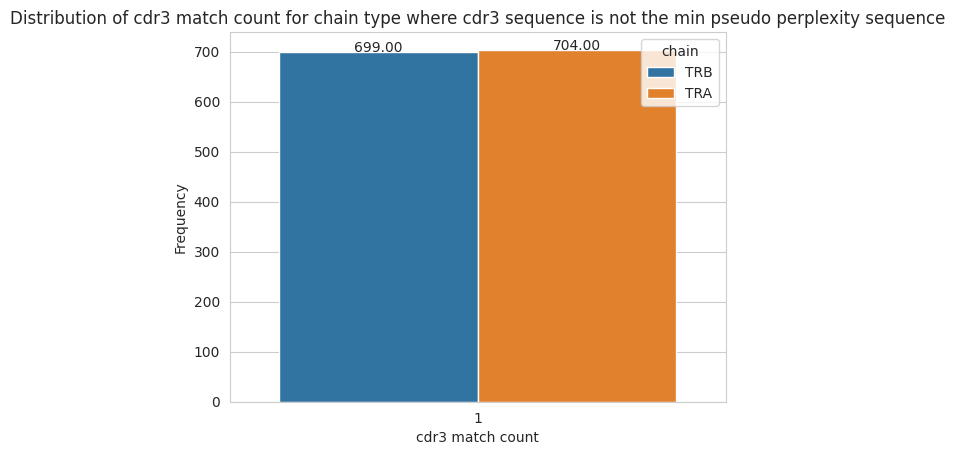

In [27]:
# plot the distribution of cdr3 match where the cdr3 sequence is not the min pseudo perplexity sequence
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='cdr3_match_topX_count', hue='chain', data=topX_not_min)
plt.title("Distribution of cdr3 match count for chain type where cdr3 sequence is not the min pseudo perplexity sequence")
# set x axis label
plt.xlabel("cdr3 match count")
# set y axis label
plt.ylabel("Frequency")
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2.,
                   p.get_height(), '{:1.2f}'.format(p.get_height()),
                   ha="center")
# save as svg high quality
plt.savefig("./single_cell_research/figures/10x_scData_all_cdr3_top10.svg", format="svg", dpi=1200)
plt.show()

In [42]:
# calculate the percentage of cdr3 match where the cdr3 sequence is the min pseudo perplexity sequence exactly or in the top X
print("TRB Percentage (kmers 11-19): " + str(((1069+699)/1838)*100) + "%")
print("TRA Percentage (kmers 11-19): " + str(((1003+704)/1805)*100) + "%")

TRB Percentage (kmers 11-19): 96.19151251360174%
TRA Percentage (kmers 11-19): 94.57063711911357%


In [40]:
print("TRB Percentage (kmers 12-17): " + str(((1182+462)/1838)*100) + "%")
print("TRA Percentage (kmers 12-17): " + str(((1010+585)/1805)*100) + "%")

TRB Percentage (kmers 12-17): 89.44504896626768%
TRA Percentage (kmers 12-17): 88.36565096952909%


##### Alignment of the top X sequences with the cdr3 sequence

In [43]:
# alingment of the top X sequences with the cdr3 sequence
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

label = topX_not_min['cdr3'].iloc[0]  # take the first row as an example
seqs = topX_not_min['pseudo_perplexity_top10_seq'].iloc[0]

for seq in seqs:
    alignments = pairwise2.align.globalxx(label, seq)
    print(format_alignment(*alignments[0]))

C----A-------SSLY--GRSYEQYF
|    |       ||    ||      
CTSVPAVYTGGPTSS--TSGR------
  Score=6

CASSLYGRSYEQYF
||||||||||||||
CASSLYGRSYEQYF
  Score=14

CAS-SL----Y-GR---SYEQYF-
|   |     | |    |      
C--TS-VPAVYTG-GPTS-----S
  Score=5

CAS-SL----Y-GRSYEQYF-
|   |     | |        
C--TS-VPAVYTG-------G
  Score=4

CAS---SLYGR--SYE-QY-----F
| |   ||     |   |      |
C-SHPRSL---CLS--HQ-MDHSVF
  Score=7

CAS-SL----Y-GR---SYEQYF---
|   |     | |    |        
C--TS-VPAVYTG-GPTS-----STS
  Score=5

CAS-SL----Y-GRSYEQYF--
|   |     | |         
C--TS-VPAVYTG-------GP
  Score=4

CASSLYGRSYEQYF
||||||||||||| 
CASSLYGRSYEQY-
  Score=13

CAS---SLYGR--SYE-QYF
| |   ||     |   |  
C-SHPRSL---CLS--HQ--
  Score=6

CA----SSLY--GRSYEQYF--
      ||    ||        
--GGPTSS--TSGR------AP
  Score=4



##### Anaysis of the 10% of sequences that are not in the top X

In [44]:
# df of the min pseudo perplexity sequence that is not the cdr3 sequence and not in the top X, df_kmers_topX minus topX_min and topX_not_min
topX_not_min_not_cdr3 = df_kmers_topX[~df_kmers_topX.index.isin(topX_min.index)]
topX_not_min_not_cdr3 = topX_not_min_not_cdr3[~topX_not_min_not_cdr3.index.isin(topX_not_min.index)]
topX_not_min_not_cdr3

,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,...,kmer_offsets,pseudo_perplexity,min_pseudo_perplexity,min_pseudo_perplexity_seq,min_pseudo_perplexity_offset,min_pseudo_perplexity_is_cdr3,pseudo_perplexity_top10,pseudo_perplexity_top10_seq,cdr3_match_topX,cdr3_match_topX_count
4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[750.2579956054688, 550.3450927734375, 814.998...",1.570277,CISQPPSPAMQASTSVEQ,1,0,"[1.5702770948410034, 2.56619930267334, 3.08404...","[CISQPPSPAMQASTSVEQ, CISQPPSPAMQASTSVEQT, CRHL...","[False, False, False, False, False, False, Fal...",0
20,ACGGCCATCCAAAGTC-1_contig_2,GGGGCAGCTGGTTGGGAAGACTGGAAGACCACCTGGGCTGTCATTG...,ACGGCCATCCAAAGTC-1,True,True,512,TRA,TRAV23DV6,None,TRAJ49,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[161.65870666503906, 193.84759521484375, 176.4...",1.380556,CISWIPSLETQPPTSV,0,0,"[1.380556344985962, 1.3864332437515259, 1.4156...","[CISWIPSLETQPPTSV, CISWIPSLETQPPTSVHL, CISWIPS...","[False, False, False, False, False, False, Fal...",0
29,GAATGAAGTAAACCTC-1_contig_1,TGGGTCTTTCCTGCATTACAGAATATGAACTAAGATACAGAAGTGG...,GAATGAAGTAAACCTC-1,True,True,539,TRA,TRAV20,None,TRAJ16,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[609.7623291015625, 998.5439453125, 659.776672...",1.400399,CARFSDGQKLLF,0,0,"[1.400398850440979, 1.4868017435073853, 1.6818...","[CARFSDGQKLLF, CTSQPLNLKTQPLISVPGF, CTSQPLNLKT...","[False, False, False, False, False, False, Fal...",0
113,TCTCATACAGGTTTCA-1_contig_3,TGGGGAGCAAGCACTCTTCTAGCCCAGAGAAGTCTGTTCCAGGACG...,TCTCATACAGGTTTCA-1,True,True,539,TRA,TRAV27,None,TRAJ49,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[130.0506134033203, 33.77565002441406, 28.8584...",6.666990,CAGSGNQFYFGT,0,0,"[6.666990280151367, 6.67097806930542, 10.68197...","[CAGSGNQFYFGT, STSVQDRVTSSIL, STSVQDRVTSSILGQ,...","[False, False, False, False, False, False, Fal...",0
130,CTCTGGTAGATAGTCA-1_contig_1,TGGGGAGGTCTCAGAATGACTTCCTTGAGAGTCCTGTTCCCCTTTC...,CTCTGGTAGATAGTCA-1,True,True,717,TRB,TRBV6-6,None,TRBJ2-7,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[55.94770812988281, 57.445655822753906, 26.923...",4.118580,CTSVPAVTRPK,0,0,"[4.118579864501953, 4.174223899841309, 4.35894...","[CTSVPAVTRPK, CVLLCQQLRDP, CSHPRSLCLSHQKQRSPTP...","[False, False, False, False, False, False, Fal...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4973,ATTATCCGTAGTAGTA-1_contig_3,GGGGTACAAGCAGAAAGCTAAGAAGCCACCGGAGCTCATGTTTGTC...,ATTATCCGTAGTAGTA-1,True,True,489,TRB,TRBV4-1,TRBD1,TRBJ1-2,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1401.3516845703125, 743.3687744140625, 667.28...",4.358948,CSHPRSLCLSHQKQRSPTP,0,0,"[4.358948230743408, 4.60116720199585, 4.615134...","[CSHPRSLCLSHQKQRSPTP, CSHPRSLCLSHQKQRSP, CSHPR...","[False, False, False, False, False, False, Fal...",0
5006,ATTATCCGTTCTGAAC-1_contig_1,TGGGAAGGCTGAGAATTTAGCTCTTTCCCAGGAGGACCAAGCCCTG...,ATTATCCGTTCTGAAC-1,True,True,702,TRB,TRBV5-1,None,TRBJ2-7,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[345.066162109375, 294.6257019042969, 273.5457...",2.395339,CEHLGAGGLGPLSLRQRW,1,0,"[2.395339012145996, 2.5058412551879883, 3.7620...","[CEHLGAGGLGPLSLRQRW, CEHLGAGGLGPLSLRQ, CEHLGAG...","[False, False, False, False, False, False, Fal...",0
5007,ATTATCCGTTCTGAAC-1_contig_2,GGGGAAGCACTCTTCTAGCCCAGAGAAGTCTGTTCCAGGACGGGCT...,ATTATCCGTTCTGAAC-1,True,True,710,TRA,TRAV27,None,TRAJ40,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[303.6431579589844, 622.8787841796875, 387.905...",9.445993,CGPAW.YRPLPLCRVNLQ,1,0,"[9.445993423461914, 10.49394702911377, 10.7858...","[CGPAW.YRPLPLCRVNLQ, CAGLTYKYIFGTGTRLKV, CGPAW...","[False, False, False, False, False, False, Fal...",0
5071,TCTGAGACAGATGGCA-1_contig_4,TGGGGACACTAAAGATGAACTATTCTCCAGGCTTAGTATCTCTGAT...,TCTGAGACAGATGGCA-1,True,True,459,T

In [45]:
# alignment of the cdr3 sequence with the min pseudo perplexity sequence that is not the cdr3 sequence and not in the top X
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

label = topX_not_min_not_cdr3['cdr3'].iloc[1]  # take the first row as an example
seq = topX_not_min_not_cdr3['min_pseudo_perplexity_seq'].iloc[1]

alignments = pairwise2.align.globalxx(label, seq)
print(format_alignment(*alignments[0]))

CALTS-S-I--L--------
|     | |  |        
C----ISWIPSLETQPPTSV
  Score=4



Text(0, 0.5, 'Frequency')

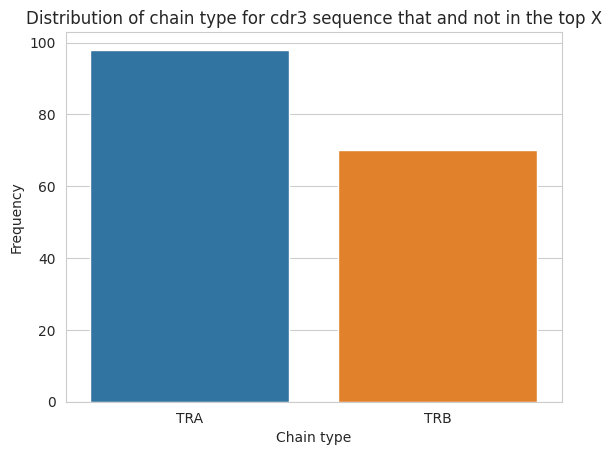

In [46]:
# plot distribution of chain type
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='chain',data=topX_not_min_not_cdr3)
plt.title("Distribution of chain type for cdr3 sequence that and not in the top X")
# set x axis label
plt.xlabel("Chain type")
# set y axis label
plt.ylabel("Frequency")

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='alignment_score', ylabel='Count'>

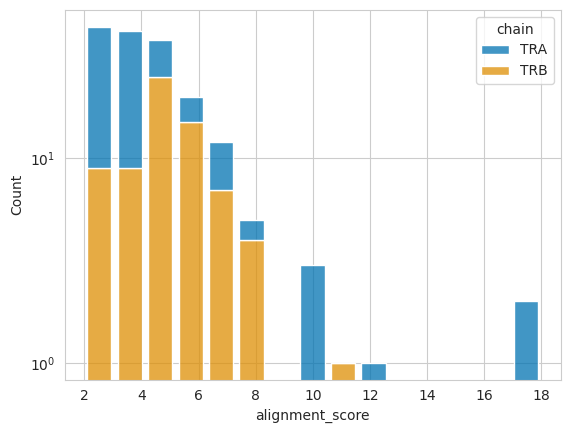

In [47]:
# calculate the alignment score for each cdr3 sequence with the min pseudo perplexity sequence that is not the cdr3 sequence and not in the top X and create plot of distribution
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
for index, row in topX_not_min_not_cdr3.iterrows():
    label = row['cdr3']
    seq = row['min_pseudo_perplexity_seq']
    alignments = pairwise2.align.globalxx(label, seq)
    topX_not_min_not_cdr3.loc[index, 'alignment_score'] = alignments[0].score

# plot distribution of alignment score
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(
    data=topX_not_min_not_cdr3,
    x='alignment_score',
    hue='chain',
    multiple='stack',
    shrink=.8,
    palette='colorblind',
    log_scale=(False, True),
)

In [48]:
top_alignment_score = 10
# show the cdr3 sequences that have an alignment score of 10
high_alignment_score = topX_not_min_not_cdr3[topX_not_min_not_cdr3['alignment_score'] > top_alignment_score]
high_alignment_score

,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,...,pseudo_perplexity,min_pseudo_perplexity,min_pseudo_perplexity_seq,min_pseudo_perplexity_offset,min_pseudo_perplexity_is_cdr3,pseudo_perplexity_top10,pseudo_perplexity_top10_seq,cdr3_match_topX,cdr3_match_topX_count,alignment_score
1049,CCATGTCCACATTAGC-1_contig_2,GGGGGTTAAAAAGAGCATCATTTTTTTGAACTGGGGTTTGGAGCCA...,CCATGTCCACATTAGC-1,True,True,441,TRA,TRAV12-2,None,TRAJ6,...,"[216.87106323242188, 238.8091278076172, 246.57...",1.325541,CSSETPSPVIQPPTSVPL,0,0,"[1.3255409002304077, 1.5587491989135742, 1.706...","[CSSETPSPVIQPPTSVPL, CSSETPSPVIQPPTSVP, CSSETP...","[False, False, False, False, False, False, Fal...",0,18.0
1281,CAGAATCGTCACTTCC-1_contig_2,GGTCTTTCCCAGGAGGACCAAGCCCTGAGCACAGACACAGTGCTGC...,CAGAATCGTCACTTCC-1,True,True,528,TRB,TRBV5-1,TRBD2,TRBJ2-2,...,"[129.21478271484375, 78.51827239990234, 110.02...",1.752156,CASSSTPGLAG,1,0,"[1.7521556615829468, 2.5058412551879883, 2.607...","[CASSSTPGLAG, CEHLGAGGLGPLSLRQ, CEHLGAGGLGPLSL...","[False, False, False, False, False, False, Fal...",0,11.0
1824,TCAGCTCAGTGCCAGA-1_contig_3,GGGGATACCAGGAAACCTCTGTTTCCTGTTCTAGGGCAGCAGTAGC...,TCAGCTCAGTGCCAGA-1,True,True,622,TRA,TRAV14DV4,None,TRAJ53,...,"[114.90227508544922, 95.82588958740234, 59.947...",4.639947,ANSGGSNYKLTF,0,0,"[4.639947414398193, 5.042199611663818, 6.21023...","[ANSGGSNYKLTF, NSGGSNYKLTF, QANSGGSNYKLTF, MRE...","[False, False, False, False, False, False, Fal...",0,12.0
1847,CGCGTTTCACGGTGTC-1_contig_2,TGGGGCATTGTCTTTCTAAACAGAGGTGAATGGACAACAGGTAATG...,CGCGTTTCACGGTGTC-1,True,True,587,TRA,TRAV25,None,TRAJ37,...,"[32.46470642089844, 95.05491638183594, 163.303...",4.356899,CTSQPPRLQM.EPTSVPAT,2,0,"[4.356899261474609, 4.7762932777404785, 5.5070...","[CTSQPPRLQM.EPTSVPAT, CTSQPPRLQM.EPTSV, LLLCQQ...","[False, False, False, False, False, False, Fal...",0,18.0


In [49]:
# show alignment of cdr3 sequence with min pseudo perplexity sequence in high_alignment_score df
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
for index, row in high_alignment_score.iterrows():
    label = row['cdr3']
    seq = row['min_pseudo_perplexity_seq']
    alignments = pairwise2.align.globalxx(label, seq)
    print(format_alignment(*alignments[0]))

CSSETPSPVIQPPTSVPLGGSYIPTF
||||||||||||||||||        
CSSETPSPVIQPPTSVPL--------
  Score=18

CASSSTPGLAGGPGTGELFF
||||||||||     |    
CASSSTPGLA-----G----
  Score=11

CAMREWVQANSGGSNYKLTF
        ||||||||||||
--------ANSGGSNYKLTF
  Score=12

CTSQPPRLQM*-EPTSVPATQAN*SL
||||||||||  ||||||||      
CTSQPPRLQM-.EPTSVPAT------
  Score=18



In [ ]:
# calculate the cdr3 sequence length for each cdr3 sequence in topX_not_min_not_cdr3
for index, row in topX_not_min_not_cdr3.iterrows():
    topX_not_min_not_cdr3.loc[index, 'cdr3_length'] = len(row['cdr3'])
# plot cdr3 sequence length distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(
    data=topX_not_min_not_cdr3,
    x='cdr3_length',
    hue='chain',
    multiple='stack',
    shrink=.8,
    palette='colorblind',
    log_scale=(False, True),
)

#### General Analysis of the min pseudo perplexity

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


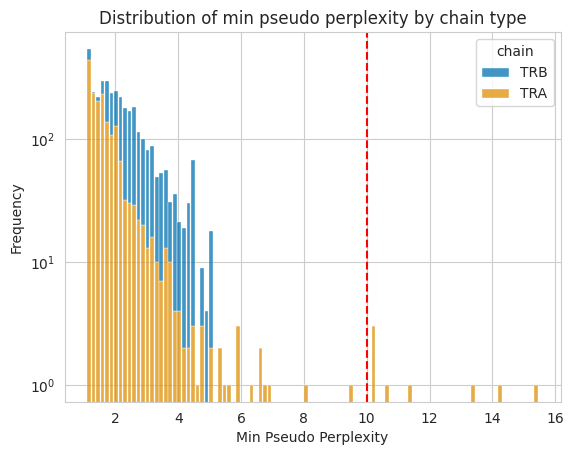

In [30]:
import matplotlib.pyplot as plt
# plot distribution of min pseudo perplexity and color by chain type
import seaborn as sns
sns.histplot(
    data=df_kmers,
    x='min_pseudo_perplexity',
    hue='chain',
    multiple='stack',
    shrink=.8,
    palette='colorblind',
    log_scale=(False, True),
)
plt.title("Distribution of min pseudo perplexity by chain type")
# set x axis label
plt.xlabel("Min Pseudo Perplexity")
# set y axis label
plt.ylabel("Frequency")
plt.axvline(x=10, color='r', linestyle='--')
# save plot in svg format in high resolution
plt.savefig('./single_cell_research/figures/min_pseudo_perplexity.svg', format='svg', dpi=1200)
plt.show()

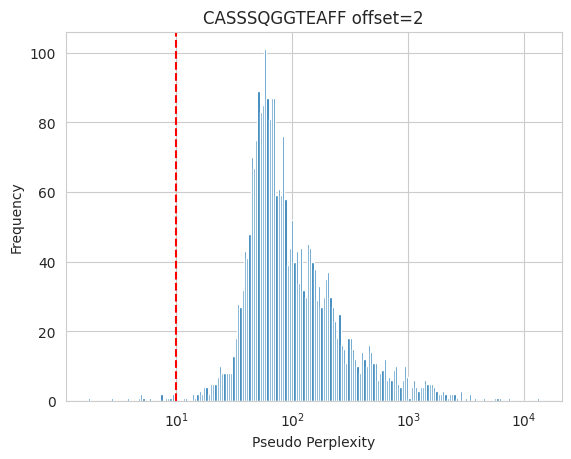

In [74]:
import matplotlib.pyplot as plt
import numpy as np
# write a function that plots the distribution of pseudo perplexity for given row
def plot_pseudo_perplexity(row):
    hist, bins, _ = plt.hist(row['pseudo_perplexity'], bins=200)
    plt.clf()
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(row['pseudo_perplexity'], bins=logbins)
    plt.xscale('log')
    plt.title(row['min_pseudo_perplexity_seq'] + ' offset=' + str(row['min_pseudo_perplexity_offset']))
    # set x axis label
    plt.xlabel("Pseudo Perplexity")
    # set bins sizes to distribute evenly
    # set y axis label
    plt.ylabel("Frequency")
    # mark red vertical line at pseudo perplexity of 10
    plt.axvline(x=10, color='r', linestyle='--')
    plt.show()

plot_pseudo_perplexity(df_kmers_topX.iloc[0])